In [1]:
import sys
sys.path.append("../")
from src.utils.wandb_utils import get_config, config_to_omegaconf

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
user = "kealexanderwang"
project = "importance-reweighing"

run_names = [
    "divine-frog-189", # resampled
    "fluent-field-198", # basic erm
]

query = {"displayName": {"$in": run_names}}

In [4]:
from typing import Tuple
device = "cuda"

def init_model(name_config: Tuple[str, dict], ckpt_name="last.ckpt"):
    
    name, config = name_config
    config = config_to_omegaconf(config)
    run_dir = config["run_dir"]
    ckpt_path = f"{run_dir}/checkpoints/{ckpt_name}"
    
    config.trainer.gpus = 0  # don't use GPU for test time
    from src.train import hydra_init
    hydra_objs = hydra_init(config)
    
    model = hydra_objs.model
    import torch
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    model.to(device)
    
    datamodule = hydra_objs.datamodule
    datamodule.setup()
    return model, datamodule

In [5]:
name_configs = get_config(user=user, project=project, query=query)

In [6]:
model_datamodule_lst = [init_model(name_config) for name_config in name_configs]

<class 'src.pl_models.imbalanced_classifier_model.ImbalancedClassifierModel'> initialized with unused kwargs: ['params_total', 'params_trainable', 'params_not_trainable']
Freezing feature extractor
Resetting final linear layer


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/u/nlp/anaconda/main/anaconda3/envs/is/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


<class 'src.pl_models.imbalanced_classifier_model.ImbalancedClassifierModel'> initialized with unused kwargs: ['params_total', 'params_trainable', 'params_not_trainable']
Freezing feature extractor
Resetting final linear layer


../src/datasets/utils.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights)


In [7]:
val_dataset = model_datamodule_lst[0][1].val_dataset
test_dataset = model_datamodule_lst[0][1].test_dataset
models = [m_d[0] for m_d in model_datamodule_lst]

In [8]:
def to_ratio(group_dict):
    total = sum(group_dict.values())
    return {g: count / total for g, count in group_dict.items()}

In [9]:
models = [m.to(device) for m in models]

# evaluate erm model on test set

In [10]:
import torch
from torch.utils.data import DataLoader

dataloader = DataLoader(test_dataset, batch_size=16)
y_trues = []
y_preds = []
group_ids = []
for x, y, g in dataloader:
    x = x.to(device)
    y = y.to(device)
    
    with torch.no_grad():
        batch = x, y
        _, _, y_pred, _, _ = models[1].step(batch)
    
    y_trues.append(y)
    y_preds.append(y_pred)
    group_ids.append(g)
    
y_trues = torch.cat(y_trues)
y_preds = torch.cat(y_preds)
group_ids = torch.cat(group_ids)

test_acc = (y_trues == y_preds).float().mean().item()

In [11]:
correct = (y_trues == y_preds).float()

# Groupby: https://twitter.com/jeremyphoward/status/1185062637341593600
idxs, vals = torch.unique(group_ids, return_counts=True)
vs = torch.split_with_sizes(correct, tuple(vals))
group_accs = {k.item(): v.mean().item() for k, v in zip(idxs, vs)}


# Groupby: https://twitter.com/jeremyphoward/status/1185062637341593600
idxs, vals = torch.unique(y_trues, return_counts=True)
vs = torch.split_with_sizes(correct, tuple(vals))
class_accs = {k.item(): v.mean().item() for k, v in zip(idxs, vs)}

In [12]:
print(test_acc)
print(group_accs)
print(class_accs)

0.803589940071106
{0: 0.8075388073921204, 1: 0.8079822659492493, 2: 0.8473520278930664, 3: 0.7305295467376709}
{0: 0.8077605366706848, 1: 0.7889407873153687}


In [13]:
from collections import Counter
test_class_counts = Counter(y_trues.tolist())
test_group_counts = Counter(group_ids.tolist())

train_class_counts =  Counter({0: 3682, 1: 1113})
train_group_counts = Counter({0: 3498, 1: 184, 2: 56, 3: 1057})

val_class_counts = Counter({0: 933, 1: 266})
val_group_counts = Counter({0: 467, 1: 466, 2: 133, 3: 133})

In [14]:
print(test_class_counts)
print(test_group_counts)

Counter({0: 4510, 1: 1284})
Counter({0: 2255, 1: 2255, 3: 642, 2: 642})


In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

<ipython-input-16-d24bd709f5b9>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR linear classifer on Waterbirds", xlabel="Group")
<ipython-input-16-d24bd709f5b9>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR linear classifer on Waterbirds", xlabel="Class")


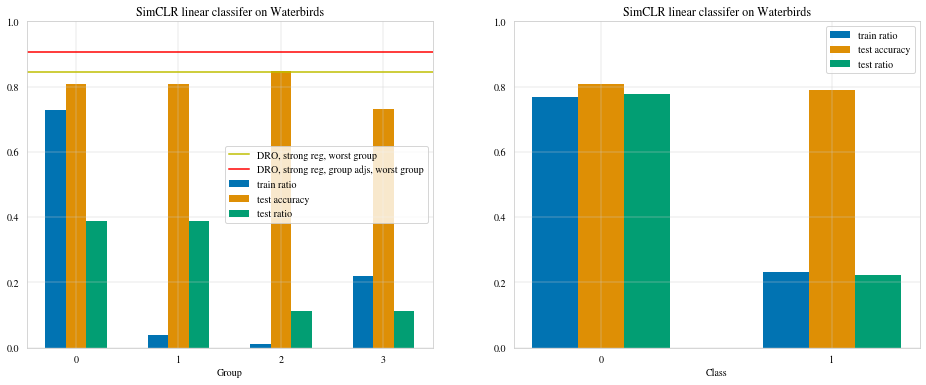

In [16]:
fig, axes = plt.subplots(figsize=(16, 6), ncols=2)

ax = axes[0]
x = np.arange(4)
ax.bar(np.array(list((to_ratio(train_group_counts).keys()))) - 0.2, to_ratio(train_group_counts).values(), width=0.2, align="center", label="train ratio")
ax.bar(np.array(list(group_accs.keys())) , group_accs.values(), width=0.2, align="center", label="test accuracy")
ax.bar(np.array(list(to_ratio(test_group_counts).keys())) + 0.2, to_ratio(test_group_counts).values(), width=0.2, align="center", label="test ratio")
ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR linear classifer on Waterbirds", xlabel="Group")
ax.axhline(0.846, color='y', label="DRO, strong reg, worst group")
ax.axhline(0.905, color='r', label="DRO, strong reg, group adjs, worst group")
ax.legend()

ax = axes[1]
x = np.arange(2)
ax.bar(np.array(list((to_ratio(train_class_counts).keys()))) - 0.2, to_ratio(train_class_counts).values(), width=0.2, align="center", label="train ratio")
ax.bar(np.array(list(class_accs.keys())) , class_accs.values(), width=0.2, align="center", label="test accuracy")
ax.bar(np.array(list((to_ratio(test_class_counts).keys()))) + 0.2, to_ratio(test_class_counts).values(), width=0.2, align="center", label="test ratio")
ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR linear classifer on Waterbirds", xlabel="Class")
ax.legend()

# evaluate resampled model

In [17]:
import torch
from torch.utils.data import DataLoader

dataloader = DataLoader(test_dataset, batch_size=16)
y_trues = []
y_preds = []
group_ids = []
for x, y, g in dataloader:
    x = x.to(device)
    y = y.to(device)
    
    with torch.no_grad():
        batch = x, y
        _, _, y_pred, _, _ = models[0].step(batch)
    
    y_trues.append(y)
    y_preds.append(y_pred)
    group_ids.append(g)
    
y_trues = torch.cat(y_trues)
y_preds = torch.cat(y_preds)
group_ids = torch.cat(group_ids)

test_acc = (y_trues == y_preds).float().mean().item()

In [18]:
correct = (y_trues == y_preds).float()

# Groupby: https://twitter.com/jeremyphoward/status/1185062637341593600
idxs, vals = torch.unique(group_ids, return_counts=True)
vs = torch.split_with_sizes(correct, tuple(vals))
group_accs = {k.item(): v.mean().item() for k, v in zip(idxs, vs)}


# Groupby: https://twitter.com/jeremyphoward/status/1185062637341593600
idxs, vals = torch.unique(y_trues, return_counts=True)
vs = torch.split_with_sizes(correct, tuple(vals))
class_accs = {k.item(): v.mean().item() for k, v in zip(idxs, vs)}

In [19]:
print(test_acc)
print(group_accs)
print(class_accs)

0.7973765730857849
{0: 0.7782705426216125, 1: 0.7960088849067688, 2: 0.867601215839386, 3: 0.7990654110908508}
{0: 0.7871397137641907, 1: 0.8333333134651184}


In [20]:
from collections import Counter
test_class_counts = Counter(y_trues.tolist())
test_group_counts = Counter(group_ids.tolist())

train_class_counts =  None
train_group_counts = None

val_class_counts = Counter({0: 933, 1: 266})
val_group_counts = Counter({0: 467, 1: 466, 2: 133, 3: 133})

In [21]:
print(test_class_counts)
print(test_group_counts)

Counter({0: 4510, 1: 1284})
Counter({0: 2255, 1: 2255, 3: 642, 2: 642})


<ipython-input-26-6d95d0c9de20>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR resampled linear classifer on Waterbirds", xlabel="Group")
<ipython-input-26-6d95d0c9de20>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR resampled linear classifer on Waterbirds", xlabel="Class")


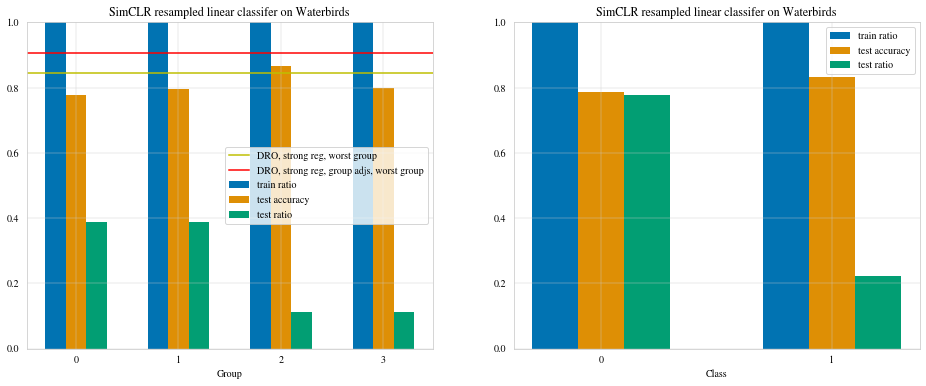

In [26]:
fig, axes = plt.subplots(figsize=(16, 6), ncols=2)

ax = axes[0]
x = np.arange(4)
ax.bar(np.arange(4) - 0.2, np.ones(4), width=0.2, align="center", label="train ratio")
ax.bar(np.array(list(group_accs.keys())) , group_accs.values(), width=0.2, align="center", label="test accuracy")
ax.bar(np.array(list(to_ratio(test_group_counts).keys())) + 0.2, to_ratio(test_group_counts).values(), width=0.2, align="center", label="test ratio")
ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR resampled linear classifer on Waterbirds", xlabel="Group")
ax.axhline(0.846, color='y', label="DRO, strong reg, worst group")
ax.axhline(0.905, color='r', label="DRO, strong reg, group adjs, worst group")
ax.legend()

ax = axes[1]
x = np.arange(2)
ax.bar(np.arange(2) - 0.2, np.ones(2), width=0.2, align="center", label="train ratio")
ax.bar(np.array(list(class_accs.keys())) , class_accs.values(), width=0.2, align="center", label="test accuracy")
ax.bar(np.array(list((to_ratio(test_class_counts).keys()))) + 0.2, to_ratio(test_class_counts).values(), width=0.2, align="center", label="test ratio")
ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR resampled linear classifer on Waterbirds", xlabel="Class")
ax.legend()